# 🚀 Quick Start

This notebook shows the *minimum steps* needed to run a electrical network optimization in a wind farm via OptiWindNet.

## Steps

An network optimization via OptiWindNet involves two components:

* A `WindFarmNetwork` containing the problem data.
* A `Router` describing the method used to solve it.

The network optimization can be performed using following steps:

1) Create a `WindFarmNetwork` instance
2) Define a router
3) Run the optimization and get the results

### 1. Create a `WindFarmNetwork` instance

The `WindFarmNetwork` component stores the turbine layout and runs optimization (storing the optimized network after running an optimization). See [WindFarmNetwork and Router](a02_WindFarmNetwork.ipynb) for some of the importnant methods and functionalities provided by this component.

In [1]:
from optiwindnet.api import WindFarmNetwork

In [2]:
# Display figures as SVG in Jupyter notebooks
%config InlineBackend.figure_formats = ['svg']

#### Load location data

> Note: For details about *OptiWindNet*'s `load_repository()`, check [Load repositories containing location data](a03_load_repositories.ipynb).

In [3]:
from optiwindnet.api import load_repository
locations = load_repository()
L = locations.doggerA

Initialize a `WindFarmNetwork` instance with a prebuilt `L` and a desired maximum cable capacity *(See [Data Input](a01_data_input.ipynb) for various input formats.)*

In [4]:
wfn = WindFarmNetwork(L=L, cables=8)

We can plot the location to make sure `wfn` is created with the correct data.

>**Tip.** In a notebook, just put `wfn` as the last line of a cell for plotting G.
>
>* Before optimization (no `G` yet), it renders the location geometry `L`.
>* If `G` exists (e.g. after a `optimize()` is run), it automatically renders `G`.
>
>We could use `wfn.plot_location()` for plotting the location geometry. For more details look into the notebook about [plotting](a04_Plotting.ipynb)

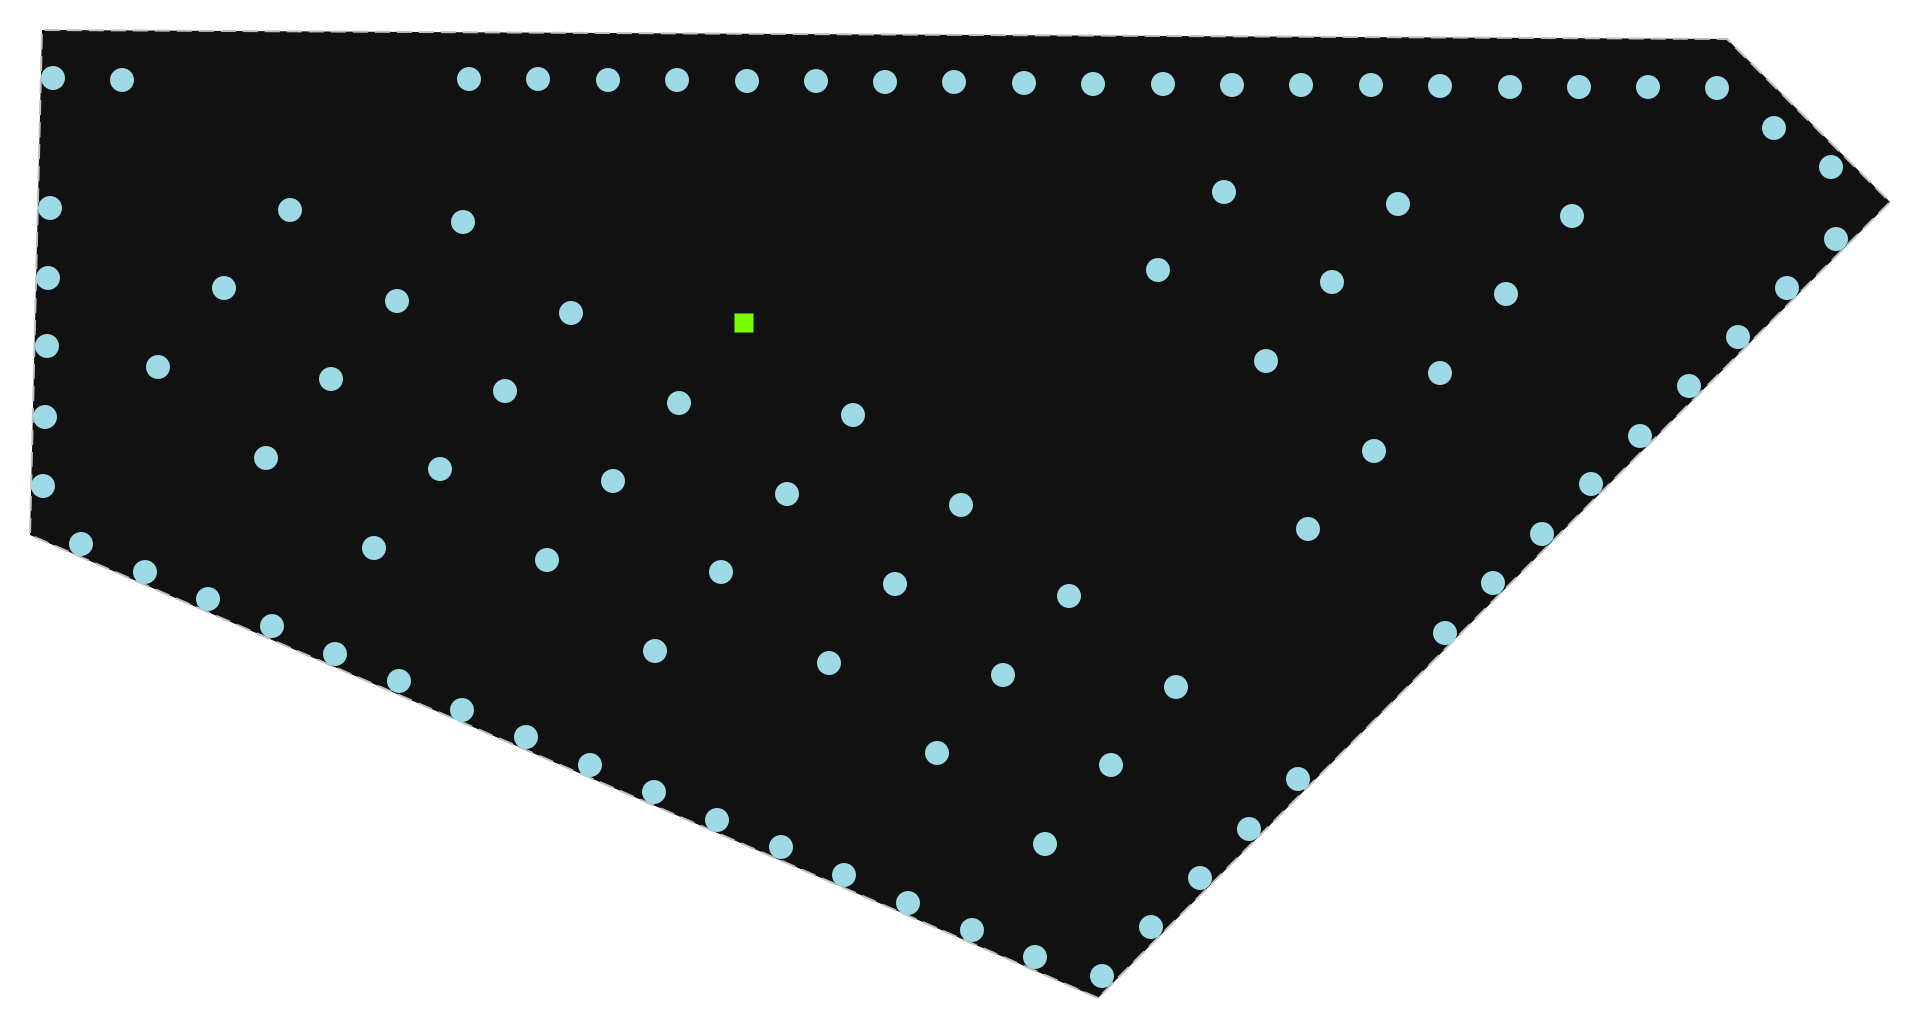

In [5]:
wfn

### 2. Define a `Router`

Three built-in routers are available in *OptiWindNet* :

| Router     | Speed | Accuracy | Notes |
|------------|-------|----------|-------|
| EWRouter   | ⭐⭐⭐  | ⭐       | Very fast heuristic |
| HGSRouter  | ⭐⭐   | ⭐⭐       | Radial topology |
| MILPRouter | ⭐    | ⭐⭐⭐      | Exact MILP solver |

See [WindFarmNetwork and Router](a02_WindFarmNetwork.ipynb) for details about routers.

#### EWRouter

To use this router, simply create an instance of the `EWRouter` class. All arguments are *optional*, making it quick and easy to get started with minimal configuration.

In [6]:
from optiwindnet.api import EWRouter

In [7]:
ew_router = EWRouter()

#### HGSRouter

To use this router, create an instance of the `HGSRouter` class. The *only required argument* is `time_limit`, which defines how long the optimization is allowed to run (in seconds).

In [8]:
from optiwindnet.api import HGSRouter

In [9]:
hgs_router = HGSRouter(time_limit=1)

#### MILPRouter

To use this router, create an instance of the `MILP` class.
You must provide:

* `solver_name`: the MILP solver to use (e.g., `'ortools'`, `'gurobi'`, `'cbc'`)
* `time_limit`: maximum time allowed for solving (in seconds)
* `mip_gap`: acceptable optimality gap (e.g., `0.005` = 0.5%)

Optional arguments:

* `verbose` *(default: False)*: set to `True` to display solver progress and detailed logs
* `solver_options`: dictionary of solver-specific parameters
* `model_options`: advanced model settings (e.g., topology, feeder configuration)

In [10]:
from optiwindnet.api import MILPRouter

In [11]:
milp_router = MILPRouter(solver_name='ortools', time_limit=20, mip_gap=0.005, verbose=True)

### 3. Run the optimization

#### EWRouter (very fast)

In [12]:
%%timeit
res_ew = wfn.optimize(router=ew_router)

29.8 ms ± 2.41 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
wfn.solution_info()

{'router': 'EWRouter', 'capacity': 8, 'iterations': 83}

In [14]:
wfn.G.graph['method_options']

{'fun_fingerprint': {'funhash': b'\x06\xe6\n\x81\x0cow\x17r\x80\xaf\xe0\xaeF:\x1b\x00\xc4\xa0u\xff\xb29\xe4\x84\xb7+\xd0\x14\x97\xa9\xde',
  'funfile': 'C:\\Users\\s213184\\docs\\git\\OptiWindNet.git\\build\\__editable__.optiwindnet-0.0.7.dev55+g9cd2048cd-py3-none-any\\optiwindnet\\heuristics\\EW_presolver.py',
  'funname': 'EW_presolver'}}

In [15]:
wfn.G.graph['iterations']

83

In [16]:
wfn.length()

264936.30102115136

Plot optimized network

> Note: we could use `wfn.plot()` for plotting the optimized network. For more details look into the notebook about [plotting](a04_Plotting.ipynb)

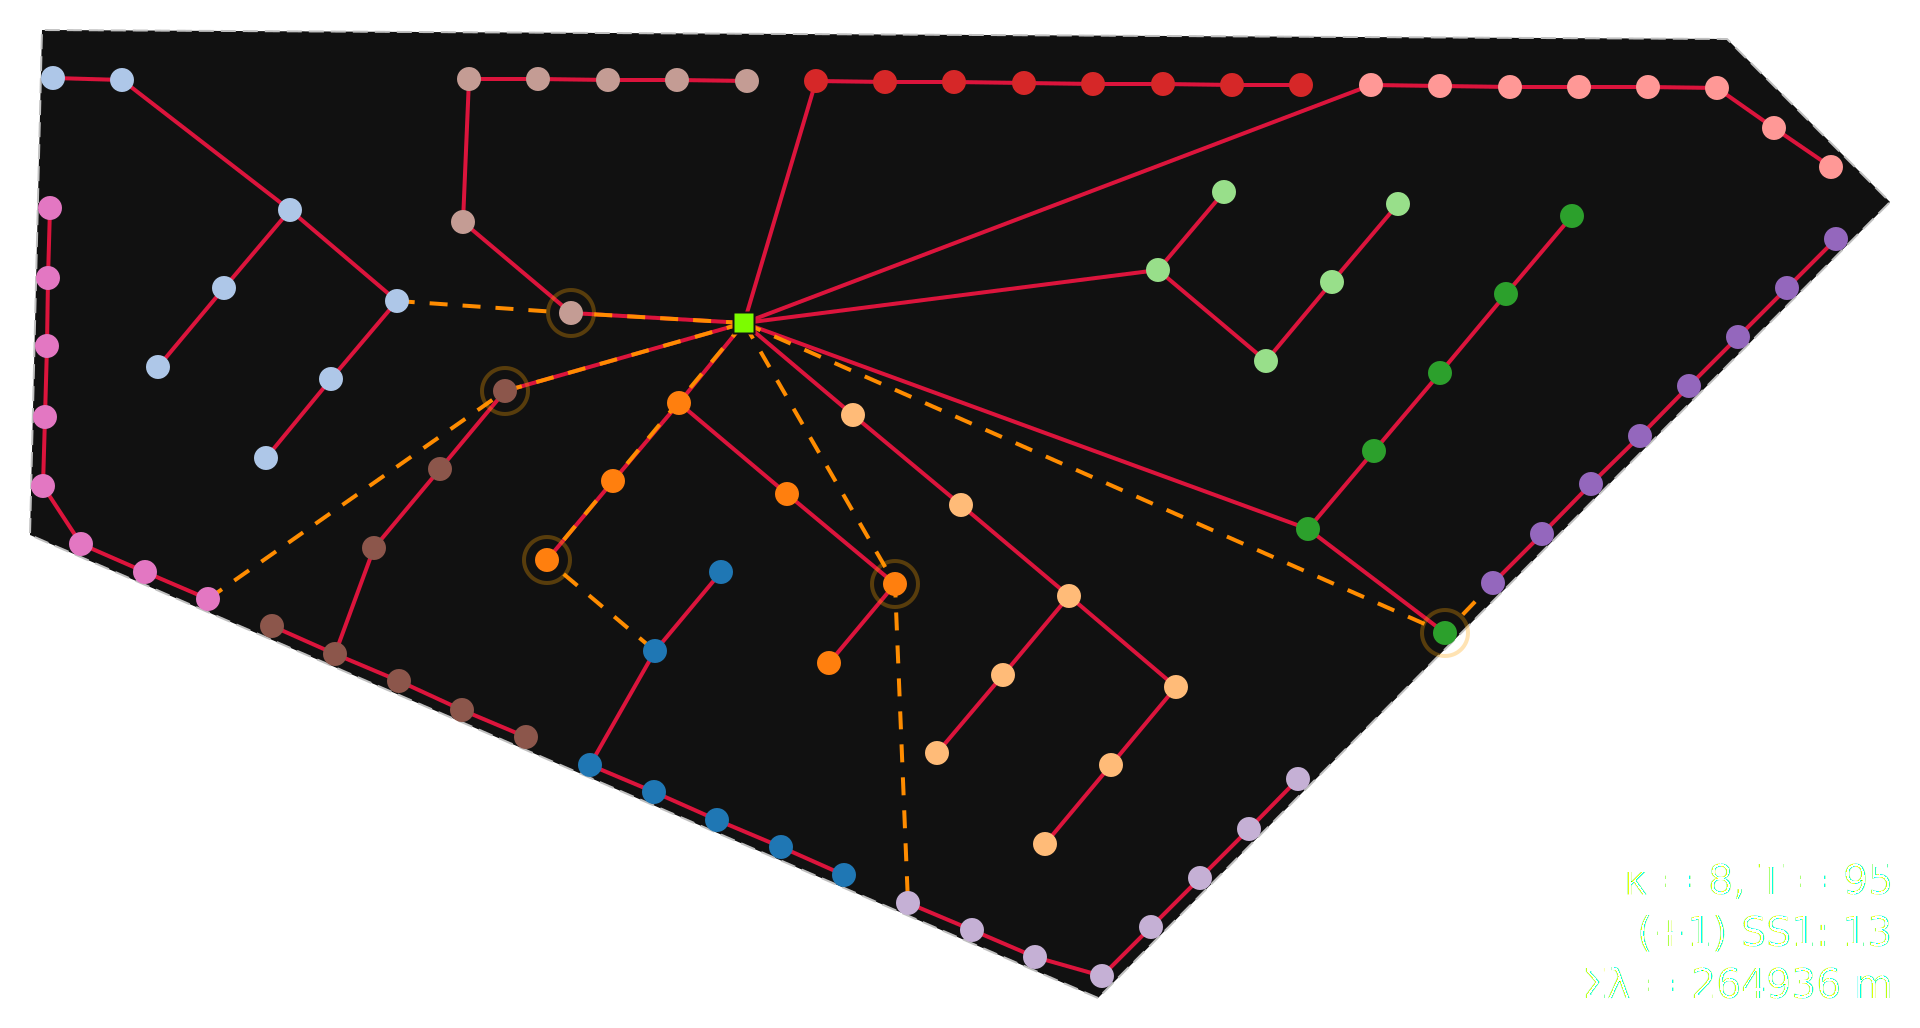

In [17]:
wfn

> **Note:** When calling `.optimize()` multiple times on the **same** `WindFarmNetwork` instance, the previously stored solution and related information (e.g., network graph, cost, length) will be **overwritten**.
> You can verify this by checking the updated total length or by re-plotting the optimized network and comparing it to the earlier result.

#### HGSRouter (fast - radial only solutions)

In [18]:
res_hgs = wfn.optimize(router=hgs_router)

In [19]:
wfn.solution_info()

{'router': 'HGSRouter',
 'capacity': 8,
 'solver_name': 'HGS-CVRP',
 'feeders_above_min': None,
 'complete': False,
 'nbGranular': 20,
 'mu': 25,
 'lambda_': 40,
 'nbElite': 4,
 'nbClose': 5,
 'nbIterPenaltyManagement': 100,
 'targetFeasible': 0.2,
 'penaltyDecrease': 0.85,
 'penaltyIncrease': 1.2,
 'seed': 6893757305993552979,
 'nbIter': 20000,
 'nbIterTraces': 500,
 'timeLimit': 1,
 'useSwapStar': True,
 'runtime': 1.0}

In [20]:
wfn.length()

243311.58718579228

> Note that with `HGSRouter`,  the optimized network has a *radial topology*, forming a single connected tree without any subtree (`HGSRouter`produces *radial-topology* networks).

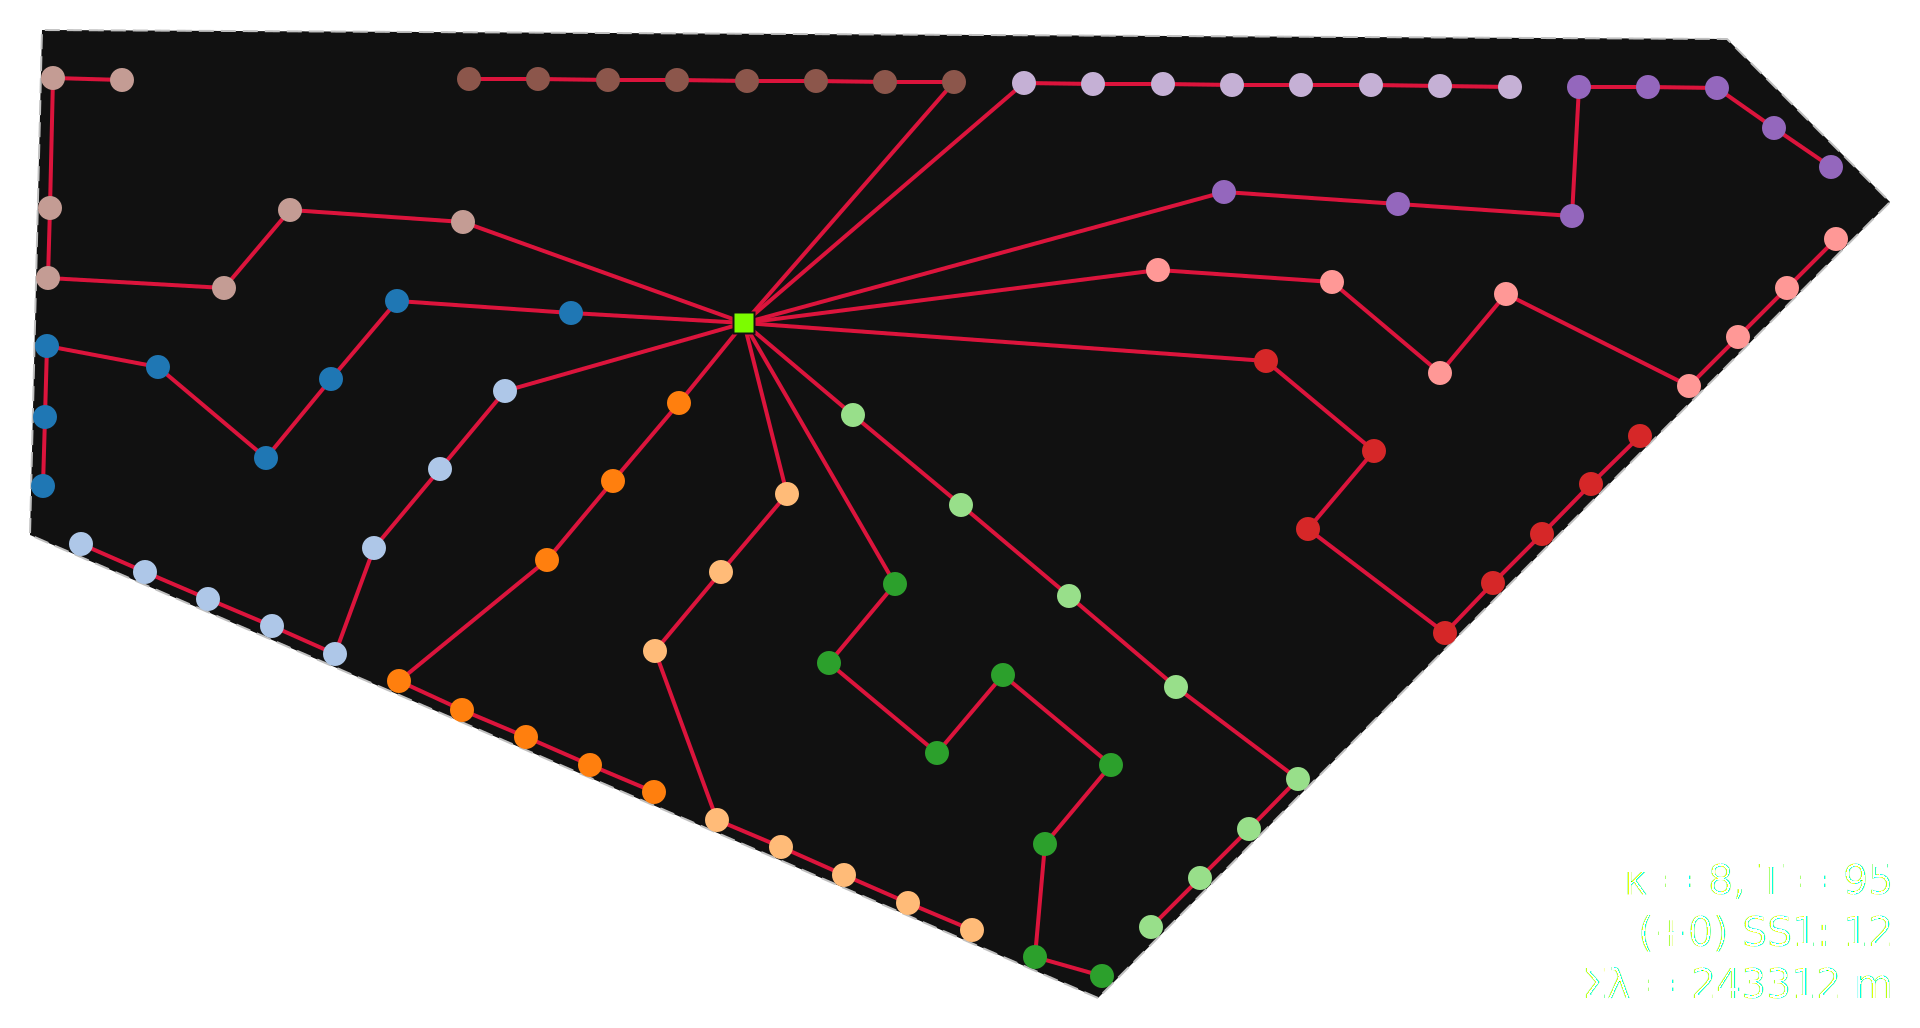

In [21]:
wfn

#### MILPRouter


(high-quality solutions with guarantees, may take several minutes)

> Note:
> * if a `WindFarmNetwork` already has a solution, `MILPRouter` will use it as a warm start.
> * To avoid warm-starting, create a **new** `WindFarmNetwork` and run MILP directly.  
> * Set `verbose=True` to see warm-start messages in the logs (The log messages of the MILP router provide information about warm-start).


In [22]:
res_milp = wfn.optimize(router=milp_router)

Using warm start: the model is initialized with the provided solution S.


Starting CP-SAT solver v9.14.6206
Parameters: max_time_in_seconds: 20 log_search_progress: true relative_gap_limit: 0.005
Setting number of workers to 16

Initial optimization model '': (model_fingerprint: 0x883d0ea4bfef9250)
#Variables: 1'690 (#bools: 845 in floating point objective) (1'500 primary variables)
  - 845 Booleans in [0,1]
  - 750 in [0,7]
  - 95 in [0,8]
#kAtMostOne: 635 (#literals: 1'926)
#kLinear1: 1'690 (#enforced: 1'690)
#kLinear3: 4
#kLinearN: 284 (#terms: 4'213)

Starting presolve at 0.00s
The solution hint is complete and is feasible.
[Scaling] Floating point objective has 845 terms with magnitude in [1409.66, 22631.9] average = 4594.28
[Scaling] Objective coefficient relative error: 1.60816e-10
[Scaling] Objective worst-case absolute error: 5.3597e-05
[Scaling] Objective scaling factor: 2.09715e+06
  6.47e-04s  0.00e+00d  [DetectDominanceRelations] 
  1.20e-02s  0.00e+00d  [operations_resea

In [23]:
wfn.solution_info()

{'router': 'MILPRouter',
 'capacity': 8,
 'solver_name': 'ortools',
 'topology': <Topology.BRANCHED: 'branched'>,
 'feeder_route': <FeederRoute.SEGMENTED: 'segmented'>,
 'feeder_limit': <FeederLimit.UNLIMITED: 'unlimited'>,
 'max_feeders': 0,
 'runtime': 20.1384063,
 'bound': 229074.00425963502,
 'objective': 240742.12313570915,
 'relgap': 0.04846729240439851,
 'termination': 'FEASIBLE'}

In [24]:
wfn.length()

240742.12313570912

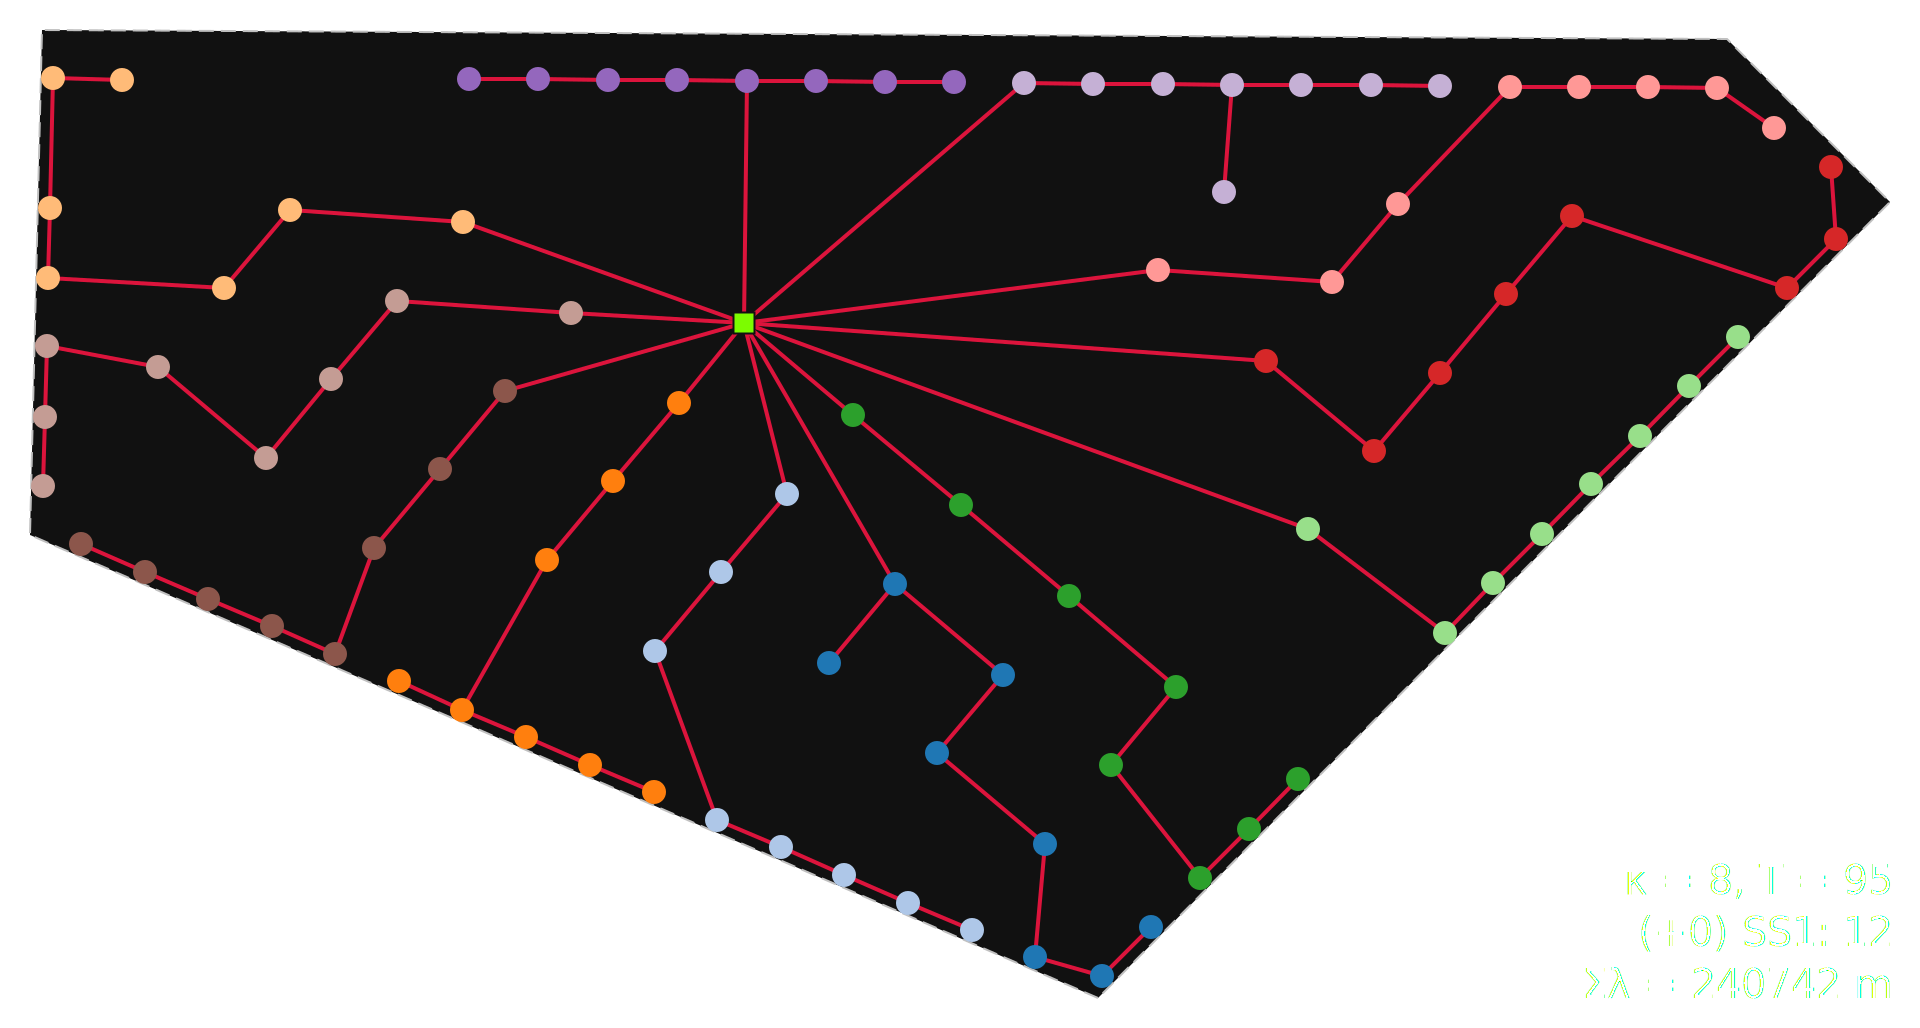

In [25]:
wfn